<a href="https://colab.research.google.com/github/anandpuntambekar/project-guidelines/blob/master/Cricketer_Language_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Language Model for Cricketers using Transfer Learning

A language model is a model that learns to predict the next word of a sentence. To predict the next word of a sentence, you actually have to know quite a lot about English and quite a lot of world knowledge.

In the code we shall  develop a language Model sing text document associated with the following cricketers

- 'AB de Villiers'
- 'Brian Lara'
- 'Rahul Dravid'
- 'Rohit Sharma'
- 'Sachin Tendulkar'
- 'Shane Warne'
- 'Virat Kolhi'

using **Transfer Learning**

#### Source of Data: https://www.kaggle.com/anandpuntambekar/cricketer-text-corpus-txt

## Transfer Learning for NLP

For Neural Networks,weight matrices start out random. So if you start out with with some random parameters and try to train those parameters to learn, you literally have thousands of  ones and zeros to actually tell you I like this one I don't like that one. 

That's clearly not enough information to learn, basically, how to speak English﹣how to speak English well enough to recognize they liked this or they didn't like this.

Sometimes that can be pretty nuanced. Particularly with cricket articals, journalist can often use sarcasm. 

So the trick, hopefully you can all guess, is to use **transfer learning**. 


We're going to start with pre-trained model that's been trained to do something different to what we're doing with it. And  then fine-tune that for Language Model for cricketers. So we're going to start with a pre-trained model that's going to do something else. 

If we need to learn "how do you speak English?" we need a much bigger set of documents. 

## Wikitext 103

Wikitext 103 dataset which is simply a subset of most of the largest articles from Wikipedia with a little bit of pre-processing that's available for download. We're basically using a language model built on Wikipedia.

Just like a pre-trained ImageNet model for vision, we've now made available a pre-trained Wikitext model for NLP not because it's particularly useful of itself (predicting the next word of sentences is somewhat useful, but not normally what we want to do), but it's a model that understands a lot about language and a lot about what language describes. So then, we can take that and we can do transfer learning to create a new language model.

## Set up for Google Colab


To use Google Colab with FastAI v1, set Runtime->Set runtime type to GPU

We run the following code in Colab to install updated versions of PyTorch and Fastai. 

In [1]:
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'
!pip install torch_nightly -f https://download.pytorch.org/whl/nightly/{accelerator}/torch_nightly.html
  
import torch
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.backends.cudnn.enabled)

!pip install fastai

Looking in links: https://download.pytorch.org/whl/nightly/cpu/torch_nightly.html
     |████████████████████████████████| 103.6MB 46kB/s 
1.2.0.dev20190805+cpu
False
True


## Upload the Text Data 

In [2]:
from google.colab import files
files.upload()

Saving ABD.txt to ABD.txt
Saving BRIAN_LARA.txt to BRIAN_LARA.txt
Saving Rahul Dravid.txt to Rahul Dravid.txt
Saving Rohit Sharma.txt to Rohit Sharma.txt
Saving Sachin Tendulkar.txt to Sachin Tendulkar.txt
Saving Shane Warne.txt to Shane Warne.txt
Saving Virat Kolhi.txt to Virat Kolhi.txt


{'ABD.txt': b'corpus: preloaded/ententen15_tt21\r\nsubcorpus: \r\nsize: 967\r\nquery: Query:[lc="AB" | lemma_lc="AB"][lc="de" | lemma_lc="de"][lc="Villiers" | lemma_lc="Villiers"]\r\nilanz.org| to watch the last ten overs, the atmosphere was unbelievable! </s><s> Who is your favourite non-New Zealand cricket player? </s><s> AB De Villiers . </s><s> After inspecting NZ\'s best cricket grounds, which comes out on top? </s><s> Hagley Oval \xe2\x80\x93 Christchurch did an amazing job to \r\nasianmirror.lk| shot that had gone over Dhoni\'s head for four but skied it to a running short third man, de Kock was run-out trying to meet AB de Villiers\' demand for stealing a single and the captain was trapped lbw at the start of the 41st over. </s><s> India took three wickets for \r\npalatinate.org.uk| from the last 10 overs of South Africa\'s innings in the final ODI in Mumbai. </s><s> Of course, facing a flourishing batsman in AB de Villiers whose pyrotechnics of 360 degree hitting have perplexe

## Looking at Imported Data
No we will look at the Files imported:

In [3]:
import glob, os
os.chdir("/content")
for file in glob.glob("*.txt"):
    print(file)

Sachin Tendulkar.txt
BRIAN_LARA.txt
Rohit Sharma.txt
ABD.txt
Virat Kolhi.txt
Rahul Dravid.txt
Shane Warne.txt


In [4]:
#As many of you may know % are special directives to Jupyter Notebook itself, they are not Python code. They are called "magics."

#These magic commands are intended to solve common problems in data analysis using Python. In fact, they control the behaviour of IPython itself.

#Magic commands act as convenient functions where Python syntax is not the most natural one.

#If somebody changes underlying library code while I'm running this, please reload it automatically
#If somebody asks to plot something, then please plot it here in this Jupyter Notebook
#We starts with the following three lines;

%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
from fastai.text import *

In [ ]:
# Batch Size:
# In order to avoid memory error( too many parameter updates for the amount of RAM ) - batch size needs to be fixed.
# bs: batch size (i.e. number of words processed at a time)

bs=48
path = "/content"

We're going to start with the language model. Now the good news is, we don't have to train the Wikitext 103 language model. Not that it's difficult﹣you can just download the wikitext 103 corpus, and run the same code. But it takes two or three days on a decent GPU, so not much point in you doing it. You may as well start with ours. Even if you've got a big corpus of like medical documents or legal documents, you should still start with Wikitext 103. There's just no reason to start with random weights. It's always good to use transfer learning if you can.

So we're gonna start fine-tuning our IMDB language model.

In [ ]:
data_lm = (TextList.from_folder(path)
           #Inputs: all the text files in path
            .filter_by_folder() #include=['train', 'test', 'unsup']
           #We may have other temp folders that contain text files so we only keep what's in train and test
            .split_by_rand_pct(0.1)
           #We randomly split and keep 10% (10,000 reviews) for validation
            .label_for_lm()           
           #We want to do a language model so we label accordingly
            .databunch(bs=bs))

/usr/local/lib/python3.6/dist-packages/fastai/data_block.py:461: UserWarning: Your validation set is empty. If this is by design, use `split_none()`
                 or pass `ignore_empty=True` when labelling to remove this warning.
  or pass `ignore_empty=True` when labelling to remove this warning.""")


We can say:

It's a list of text files﹣the full IMDB actually is not in a CSV. Each document is a separate text file.
Say where it is﹣in this case we have to make sure we just to include the train and test folders.
We randomly split it by 0.1.
Now this is interesting﹣10%. Why are we randomly splitting it by 10% rather than using the predefined train and test they gave us? This is one of the cool things about transfer learning. Even though our validation set has to be held aside, it's actually only the labels that we have to keep aside. So we're not allowed to use the labels in the test set. If you think about in a Kaggle competition, you certainly can't use the labels because they don't even give them to you. But you can certainly use the independent variables. So in this case, you could absolutely use the text that is in the test set to train your language model. This is a good trick﹣when you do the language model, concatenate the training and test set together, and then just split out a smaller validation set so you've got more data to train your language model. So that's a little trick.

So if you're doing NLP stuff on Kaggle, for example, or you've just got a smaller subset of labeled data, make sure that you use all of the text you have to train in your language model, because there's no reason not to.

How are we going to label it? Remember, a language model kind of has its own labels. The text itself is labels so label for a language model (label_for_lm) does that for us.
And create a data bunch and save it. That takes a few minutes to tokenize and numericalize.
Since it takes some few minutes, we save it. Later on you can just load it. No need to run it again.

In [ ]:
data_lm.show_batch()

/usr/local/lib/python3.6/dist-packages/fastai/text/data.py:339: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  idx_min = (t != self.pad_idx).nonzero().min()


In [ ]:
import os
os.getcwd()

'/content'

At this point things are going to look very familiar. We create a learner:

But instead of creating a CNN learner, we're going to create a language model learner. So behind the scenes, this is actually not going to create a CNN (a convolutional neural network), it's going to create an RNN (a recurrent neural network). We're going to be learning exactly how they're built over the coming lessons, but in short they're the same basic structure. The input goes into a weight matrix (i.e. a matrix multiply), that then you replace the negatives with zeros, and it goes into another matrix multiply, and so forth a bunch of times. So it's the same basic structure.

As usual, when we create a learner, you have to pass in two things:

The data: so here's our language model data
What pre-trained model we want to use: here, the pre-trained model is the Wikitext 103 model that will be downloaded for you from fastai if you haven't used it before just like ImageNet pre-trained models are downloaded for you.
This here (drop_mult=0.3) sets the amount of dropout. We haven't talked about that yet. We've talked briefly about this idea that there is something called regularization and you can reduce the regularization to avoid underfitting. So for now, just know that by using a number lower than one is because when I first tried to run this, I was under fitting. So if you reduced that number, then it will avoid under fitting.

Okay. so we've got a learner, we can lr_find and looks pretty standard:

In [ ]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

In [ ]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


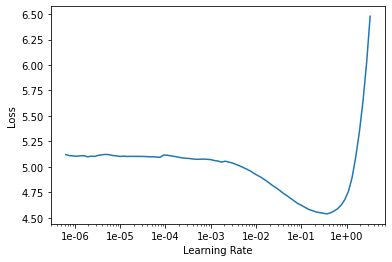

In [ ]:
learn.recorder.plot()

Then we can fit one cycle.

In [ ]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

What's happening here is we are just fine-tuning the last layers. Normally after we fine-tune the last layers, the next thing we do is we go unfreeze and train the whole thing. So here it is:

In [ ]:
learn.save('fit_head')
#learn.load('fit_head')

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (7 items)
x: LMTextList
xxbos corpus : preloaded / ententen15_tt21 
  subcorpus : 
  size : 1020 
  query : xxunk " | xxunk " | xxunk " ] 
  blogspot.in| the xxup mak xxmaj pataudi xxmaj memorial lecture in xxmaj kolkata on xxmaj november 12 , 2014 ? 1 ) xxmaj sourav xxmaj ganguly 2 ) xxup vvs xxmaj laxman 3 ) xxmaj sachin xxmaj tendulkar 4 ) xxmaj rahul xxmaj dravid 5 ) xxmaj sunil xxmaj gavaskar < / s><s > 3 . < / s><s > xxmaj the two - day xxup xxunk xxmaj summit was held in which of the following cities in xxmaj november 2014 ? 1 ) xxmaj perth 2 ) 
  indiancricketers.net| at least a xxunk probability that xxunk xxunk have already xxunk because of man - made xxunk xxunk . < / s><s > xxmaj when xxmaj rahul xxmaj dravid was playing for xxmaj team xxmaj india , he hardly used to laugh . < / s><s > xxmaj he was considered as an extremely serious guy who xxunk very 
  indiancricketers.net| quite xxunk and does n't look so much xxunk

As you can see, even on a pretty beefy GPU that takes two or three hours. In fact, I'm still under fitting. So probably tonight, I might train it overnight and try and do a little bit better. I'm guessing I could probably train this a bit longer because you can see the accuracy hasn't started going down again. So I wouldn't mind try to train that a bit longer. But the accuracy, it's interesting. 0.3 means we're guessing the next word of the movie review correctly about a third of the time. That sounds like a pretty high number﹣the idea that you can actually guess the next word that often. So it's a good sign that my language model is doing pretty well. For more limited domain documents (like medical transcripts and legal transcripts), you'll often find this accuracy gets a lot higher. So sometimes this can be even 50% or more. But 0.3 or more is pretty good.

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(25, 1e-3, moms=(0.8,0.7))

In [ ]:
learn.save('fine_tuned')

In [ ]:
learn.export()

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/module.py:385: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations.
  if param.grad is not None:
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/module.py:385: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations.
  if 

In [ ]:
TEXT = "Brian lara and shane warne"
N_WORDS = 40
N_SENTENCES = 10

You can now run learn.predict and pass in the start of a sentence, and it will try and finish off that sentence for you.

In [ ]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

Brian lara and shane warne children " < / s><s > " The numbers of many in the playing world class * are very significantly lesser than the likes of Shane Warne , especially the first two players to score 10,000 runs
Brian lara and shane warne | Cricket Legends : The Day < / s><s > Brian Lara International Cricket 2007 ; International Cricket 2007 ( PS3 
  arysports.tv| and Brian Lara
Brian lara and shane warne respectively ? < / s><s > Which platform is well known for its striking simplicity of thought , the England 
  sahilonline.org| ? < / s><s > What needs your support ? < / s><s >
Brian lara and shane warne vs Sachin Tendulkar Cricket All Stars Series 2015 Who Will Win Full Details on matchpredictions . < / s><s > IN Tendulkar and 
  matchpredictions.in| vs
Brian lara and shane warne how he got out on a spinning wicket ! < / s><s > What is more interesting is that Sachin needed to be part of the 
  matchpredictions.in| and possibly a great deal of nostalgia in the air
Brian lara an